# Tarea 1 - AST0311 - Astrofísica General 🪐

- Camila Ferrus
- Marcelo Ojeda
- Sofía Troncoso

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
import numpy as np
import astropy.constants as const
import astropy.units as u
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)
from scipy.signal import argrelextrema
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.integrate import trapezoid

### 1.- Un espectro solar (flujo específico monocromático $F_{\lambda}$ como función de la longitud de onda $\lambda$) de muy alta resolución y que cubre un amplio rango espectral se encuentra publicado por la _National Renewable Energy Laboratory_ de Estados Unidos. Los datos están dados en unidades de micrones (μm) y W $m^{-2}$ $μm^{-1}$. El flujo que se entrega es aquél que se observaría desde arriba de la atmósfera terrestre.

**a) Descargue el espectro a su computador, y luego conviértalo a unidades de Å y $erg$ $cm^{-2}$ $s^{-1}$ $Å^{-1}$. Confeccione un gráfico mostrando $F_{\lambda} = f(\lambda)$, utilizando estas últimas unidades. Como el espectro es de muy alta resolución, se recomienda utilizar líneas lo suficientemente finas, de modo a que se alcancen a ver los espectros con el máximo de detalle posible.**

In [112]:
# Quitar las columnas Unnamed
spec_raw = pd.read_excel('e490_00a_amo.xls')
spec = pd.DataFrame()
for key in spec_raw.keys():
    if key.startswith("Unnamed"):
        continue
    else:
        spec[key] = spec_raw[key]

# Agregar una columna con Wavelength en Å
wavelens_angstrom = []
for wavelen in spec["Wavelength, microns"]:
    wavelen_nm = wavelen * u.micron
    wavelen_angstrom = wavelen_nm.to(u.Angstrom)
    wavelens_angstrom.append(wavelen_angstrom.value)

spec["Wavelength, Å"] = wavelens_angstrom

# También, agregamos una columna convirtiendo Wavelength en frecuencia
frequencies = []
for wavelen in spec["Wavelength, Å"]:
    wavelen_ang = wavelen * u.Angstrom
    wavelen_meter = wavelen_ang.to(u.m)
    wavelen_to_freq = const.c / wavelen_meter
    frequencies.append(wavelen_to_freq.value)

spec["Frequency, Hz"] = frequencies

# Agregar una columna con E-490 en erg cm^-2 s^-1 Å^-1
e490_erg = []
for flux in spec["E-490 W/m2/micron"]:
    flux = flux * u.W * u.m ** -2 * u.micron ** -1
    flux_erg = flux.to(u.erg * u.cm ** -2 * u.s ** -1 * u.Angstrom ** -1)
    e490_erg.append(flux_erg.value)

spec["E-490 erg/cm2/s/Å"] = e490_erg
spec


,"Wavelength, microns",E-490 W/m2/micron,"Wavelength, nm","Wavelength, µm","Wehrli, W/m2/µm","Wehrli, W/m2/nm","Wavelength, Å","Frequency, Hz",E-490 erg/cm2/s/Å
0,0.1195,6.190000e-02,199.5,0.1995,5.0,0.005,1195.0,2.508723e+15,6.190000e-03
1,0.1205,5.614000e-01,200.5,0.2005,7.0,0.007,1205.0,2.487904e+15,5.614000e-02
2,0.1215,4.901000e+00,201.5,0.2015,7.0,0.007,1215.0,2.467428e+15,4.901000e-01
3,0.1225,1.184000e+00,202.5,0.2025,8.0,0.008,1225.0,2.447285e+15,1.184000e-01
4,0.1235,4.770000e-02,203.5,0.2035,9.0,0.009,1235.0,2.427469e+15,4.770000e-03
...,...,...,...,...,...,...,...,...,...
1692,200.0000,1.530000e-06,NaN,NaN,NaN,NaN,2000000.0,1.498962e+12,1.530000e-07
1693,250.0000,6.280000e-07,NaN,NaN,NaN,NaN,2500000.0,1.199170e+12,6.280000e-08
1694,300.0000,2.950000e-07,NaN,NaN,NaN,NaN,3000000.0,9.993082e+11,2.950000e-08
1695,400.0000,1.010000e-07,NaN,NaN,NaN,NaN,4000000.0,7.494811e+11,1.010000e-08


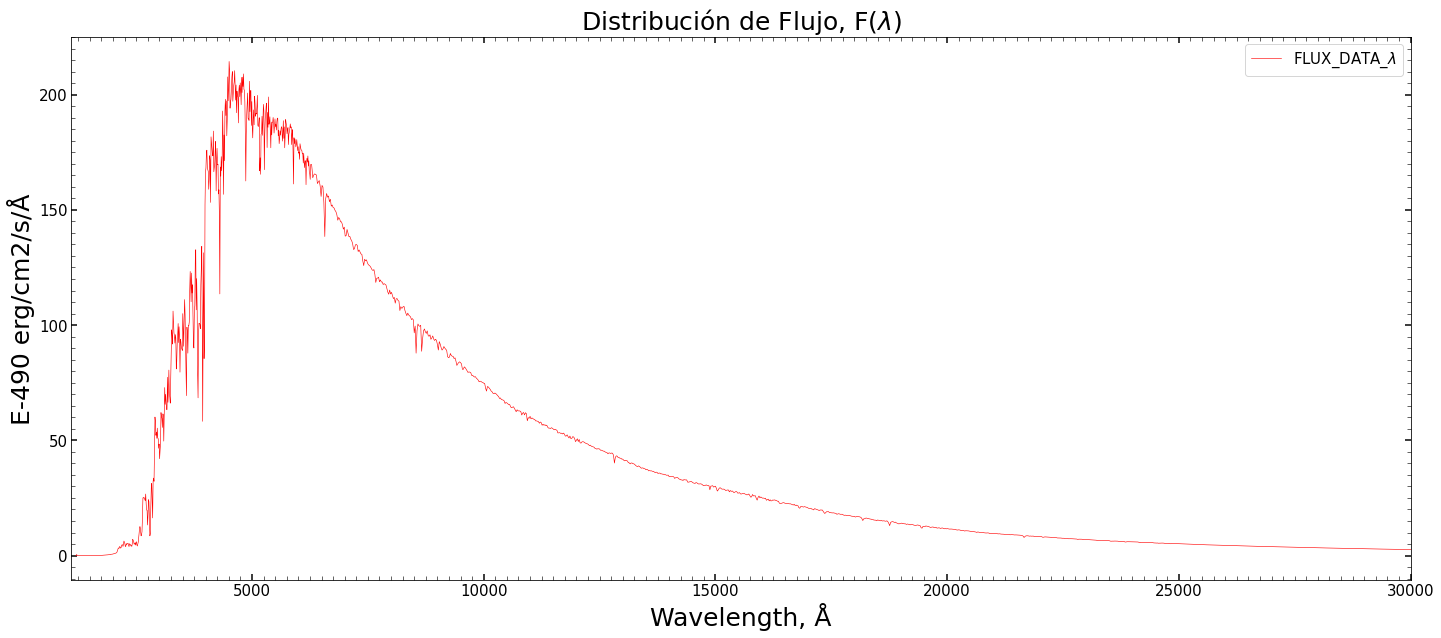

In [113]:
fig, ax1 = plt.subplots(figsize=(24, 10))
ax1.plot(spec["Wavelength, Å"], spec["E-490 erg/cm2/s/Å"], c="red", label=r'FLUX_DATA_$\lambda$', linewidth=0.6)
ax1.set_title(r'Distribución de Flujo, F($\lambda$)', fontsize=25)
ax1.set_ylabel('E-490 erg/cm2/s/Å', fontsize=25)
ax1.set_xlabel('Wavelength, Å', fontsize=25)
ax1.set_xlim(1100, 30000)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)

ax1.xaxis.set_minor_locator(MultipleLocator(250))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)
ax1.legend(fontsize=15, markerscale=5)

**b) Usando un programa simple escrito en algún lenguaje de programación que le resulte conveniente, transforme el flujo monocromático de la representación $F_{\lambda}$ a la $F_{\nu}$, cuidando para que esa transformación satisfaga las exigencias discutidas en clases. Grafique ahora $F_{\nu} = f(\lambda)$.**

Sabemos que el flujo F puede ser interpretado como la suma de contribuciones diferenciales de todas las frecuencias que componen el espectro:

$$dF(\nu) = \frac{\partial F}{\partial \nu} \equiv F_{\nu}d\nu$$

O, también puede ser interpretado por unidad de longitud de onda, de la forma:

$$dF(\lambda) = \frac{\partial F}{\partial \lambda} \equiv F_{\lambda}d\lambda$$

Como la energía no puede depender de la formulación que se esté utilizando, debe valer, en valor absoluto:

$$|F_{\nu}d\nu| = |F_{\lambda}d\lambda|$$

Luego, podemos encontrar una expresión de conversión de la forma:

$$F_{\lambda} = F_{\nu}\left|\frac{d\nu}{d\lambda}\right| = F_{\nu}\frac{c}{\lambda^{2}}$$

(Clocchiatti & Catelan, 2017, p.9)

Entonces, podemos hacer una función que convierta nuestros datos de longitud de onda a frecuencia, dada la expresión:

$$F_{\lambda}\frac{\lambda^{2}}{c} = F_{\nu}$$

In [114]:
def flux_wave_to_freq(flux_wavelength, wavelength):
    flux_hz = flux_wavelength * ((wavelength ** 2) / const.c.to(u.Angstrom / u.s).value)
    return flux_hz

Luego podemos crear una nueva columna de datos, con el flujo en unidades $erg$ $cm^{-2}$ $s^{-1}$ $Hz^{-1}$:

In [115]:
flux_hz = []
for i in range(len(spec["E-490 erg/cm2/s/Å"])):
    flux = spec["E-490 erg/cm2/s/Å"][i]
    wavelen = spec["Wavelength, Å"][i]
    flux_converted = flux_wave_to_freq(flux, wavelen)
    flux_hz.append(flux_converted)

spec["E-490 erg/cm2/s/Hz"] = flux_hz
spec

,"Wavelength, microns",E-490 W/m2/micron,"Wavelength, nm","Wavelength, µm","Wehrli, W/m2/µm","Wehrli, W/m2/nm","Wavelength, Å","Frequency, Hz",E-490 erg/cm2/s/Å,E-490 erg/cm2/s/Hz
0,0.1195,6.190000e-02,199.5,0.1995,5.0,0.005,1195.0,2.508723e+15,6.190000e-03,2.948531e-15
1,0.1205,5.614000e-01,200.5,0.2005,7.0,0.007,1205.0,2.487904e+15,5.614000e-02,2.719104e-14
2,0.1215,4.901000e+00,201.5,0.2015,7.0,0.007,1215.0,2.467428e+15,4.901000e-01,2.413329e-13
3,0.1225,1.184000e+00,202.5,0.2025,8.0,0.008,1225.0,2.447285e+15,1.184000e-01,5.926567e-14
4,0.1235,4.770000e-02,203.5,0.2035,9.0,0.009,1235.0,2.427469e+15,4.770000e-03,2.426787e-15
...,...,...,...,...,...,...,...,...,...,...
1692,200.0000,1.530000e-06,NaN,NaN,NaN,NaN,2000000.0,1.498962e+12,1.530000e-07,2.041412e-13
1693,250.0000,6.280000e-07,NaN,NaN,NaN,NaN,2500000.0,1.199170e+12,6.280000e-08,1.309239e-13
1694,300.0000,2.950000e-07,NaN,NaN,NaN,NaN,3000000.0,9.993082e+11,2.950000e-08,8.856127e-14
1695,400.0000,1.010000e-07,NaN,NaN,NaN,NaN,4000000.0,7.494811e+11,1.010000e-08,5.390396e-14


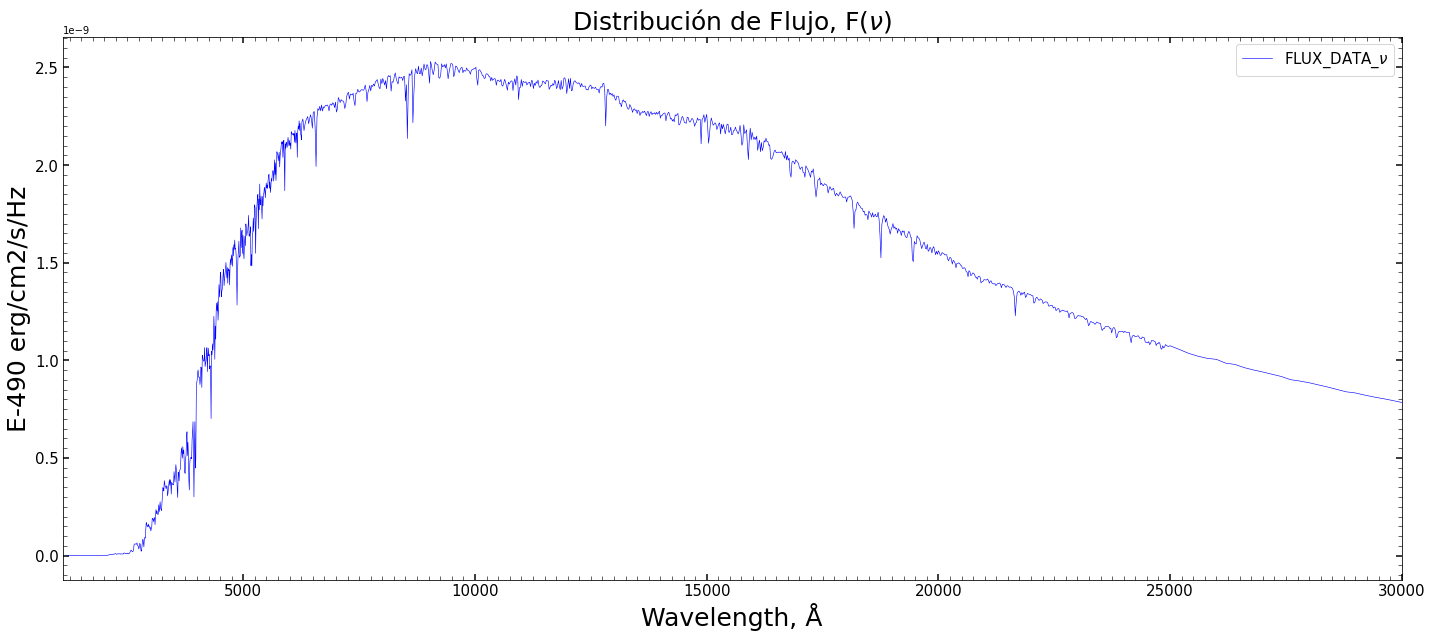

In [116]:
fig, ax1 = plt.subplots(figsize=(24, 10))
ax1.plot(spec["Wavelength, Å"], spec["E-490 erg/cm2/s/Hz"], c="blue", label=r'FLUX_DATA_$\nu$', linewidth=0.6)
ax1.set_title(r'Distribución de Flujo, F($\nu$)', fontsize=25)
ax1.set_ylabel('E-490 erg/cm2/s/Hz', fontsize=25)
ax1.set_xlabel('Wavelength, Å', fontsize=25)
ax1.set_xlim(1100, 30000)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)

ax1.xaxis.set_minor_locator(MultipleLocator(250))
ax1.yaxis.set_minor_locator(MultipleLocator(0.00000000005))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)
ax1.legend(fontsize=15, markerscale=5)

In [117]:
# Primero escalaremos el flujo en función de la frecuencia, para poder compararlo visualmente
# con el espectro del flujo en función de la longitud de onda

def scale_flux_frec(flux_hz):
    return flux_hz * 100000000000

spec["Scaled Flux, Hz"] = scale_flux_frec(spec["E-490 erg/cm2/s/Hz"])

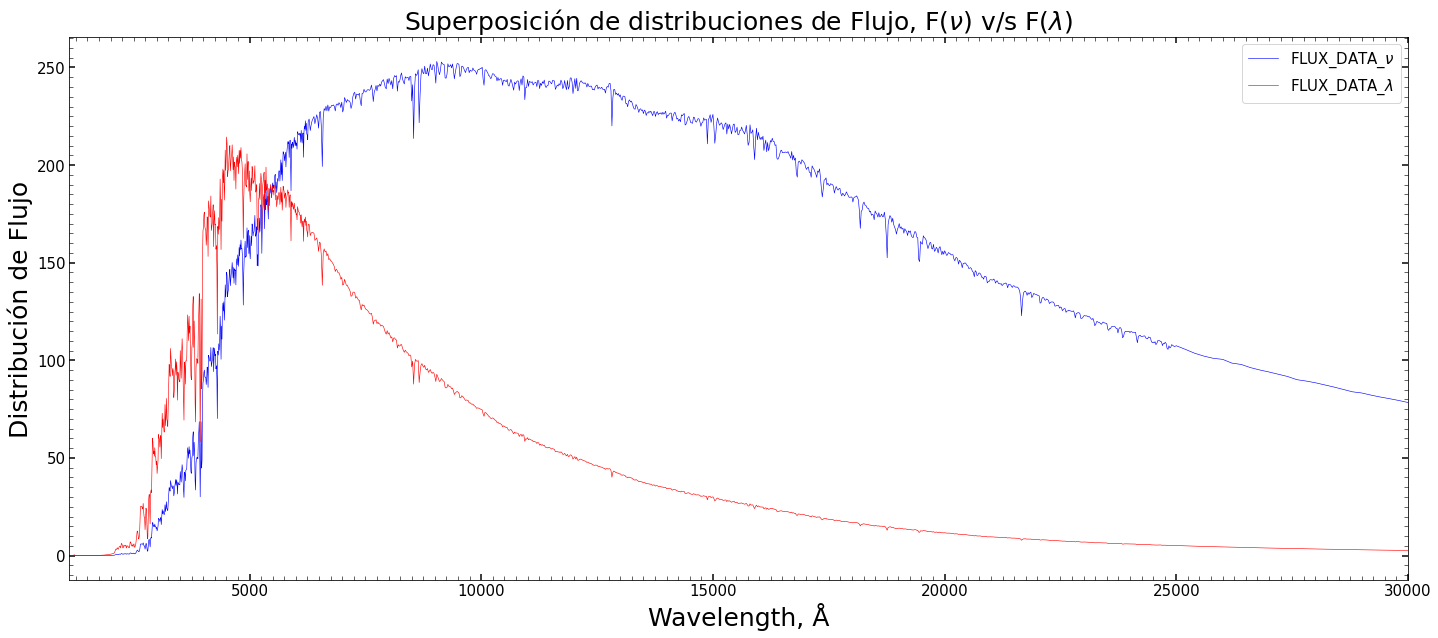

In [118]:
fig, ax1 = plt.subplots(figsize=(24, 10))
ax1.plot(spec["Wavelength, Å"], spec["Scaled Flux, Hz"], c="blue", label=r'FLUX_DATA_$\nu$', linewidth=0.6)
ax1.plot(spec["Wavelength, Å"], spec["E-490 erg/cm2/s/Å"], c="red", label=r'FLUX_DATA_$\lambda$', linewidth=0.6)
ax1.set_title(r'Superposición de distribuciones de Flujo, F($\nu$) v/s F($\lambda$)', fontsize=25)
ax1.set_ylabel('Distribución de Flujo', fontsize=25)
ax1.set_xlabel('Wavelength, Å', fontsize=25)
ax1.set_xlim(1100, 30000)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)

ax1.xaxis.set_minor_locator(MultipleLocator(250))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)
ax1.legend(fontsize=15, markerscale=5)

**c) ¿Los peaks de las distribuciones $F_{\lambda} = f(\lambda)$ y $F_{\nu} = f(\lambda)$ se encuentran al mismo valor de $\lambda$? Interprete ese resultado.**

In [119]:
# A través de la función argrelextrema de scipy.signal buscamos los "antipeaks" de la distribución,
# es decir, los peaks que representan las líneas de absorción del espectro del Sol,
# para poder comparar entre las dos funciones.

antipeaks_list_lambda_over_500 = np.array([data for data in spec["E-490 erg/cm2/s/Å"][500:]])
antipeaks_list_lambda_under_500 = np.array([data for data in spec["E-490 erg/cm2/s/Å"][:500]])
antipeaks_over_500 = argrelextrema(antipeaks_list_lambda_over_500, np.less, order=5)
antipeaks_under_500 = argrelextrema(antipeaks_list_lambda_under_500, np.less, order=20)

antipeaks = [antipeak for antipeak in antipeaks_under_500[0]]
for antipeak in antipeaks_over_500[0]:
    antipeaks.append(antipeak + 500)

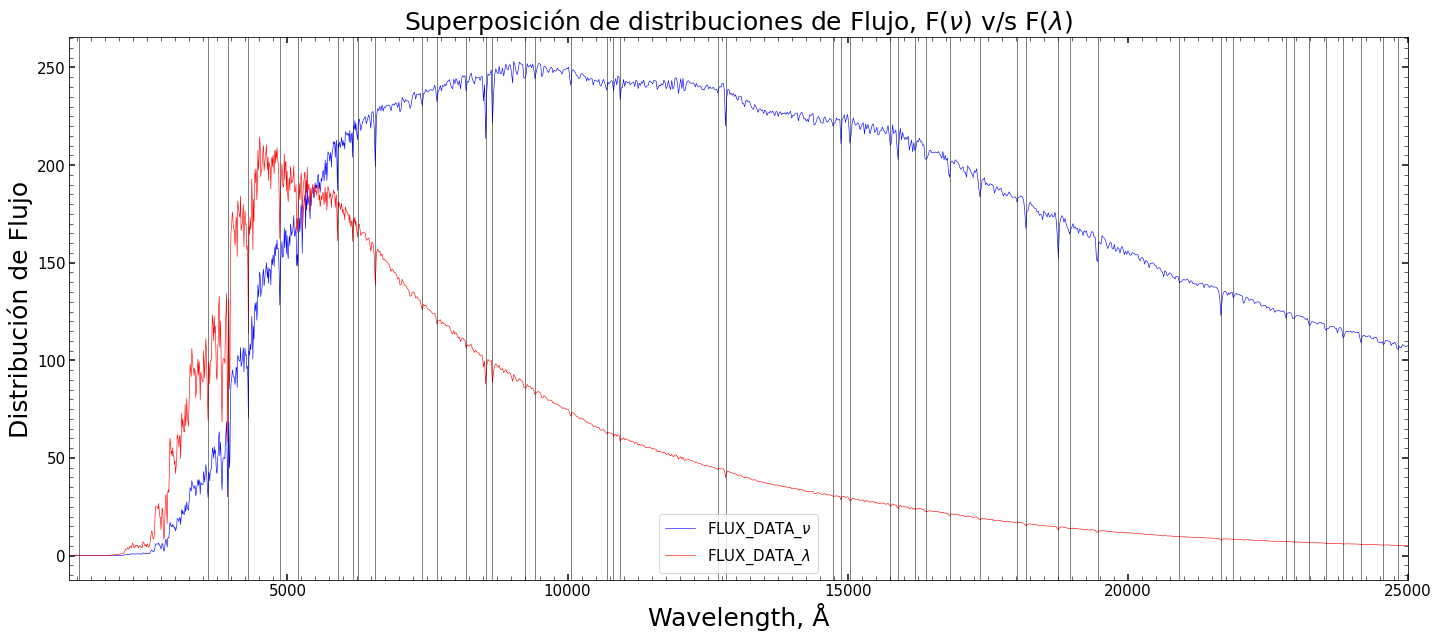

In [120]:
# Graficamos las distribuciones de flujo, junto con algunas líneas importantes que
# permitan observar y comparar la distribución de peaks en ambas funciones

fig, ax1 = plt.subplots(figsize=(24, 10))
ax1.plot(spec["Wavelength, Å"], spec["Scaled Flux, Hz"], c="blue", label=r'FLUX_DATA_$\nu$', linewidth=0.6)
ax1.plot(spec["Wavelength, Å"], spec["E-490 erg/cm2/s/Å"], c="red", label=r'FLUX_DATA_$\lambda$', linewidth=0.6)
ax1.set_title(r'Superposición de distribuciones de Flujo, F($\nu$) v/s F($\lambda$)', fontsize=25)
ax1.set_ylabel('Distribución de Flujo', fontsize=25)
ax1.set_xlabel('Wavelength, Å', fontsize=25)
ax1.set_xlim(1100, 25000)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)

ax1.xaxis.set_minor_locator(MultipleLocator(250))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)
ax1.legend(fontsize=15, markerscale=5)

# estas lineas son las que grafican los peaks
for peak in antipeaks:
    ax1.axvline(spec["Wavelength, Å"][peak], color='black', linestyle='-', linewidth=0.5)

Al observar y comparar algunas de las líneas más notorias de los espectros, observamos que en general los peaks se encuentran en exactamente los mismos valores de longitud de onda, lo cual es consistente con lo expuesto en Clocchiatti & Catelan (2017), ya que una expresión de energía debe ser siempre igual independiente de la formulación que se esté utilizando; en este caso, tenemos una expresión de energía como función de longitud de onda y otra en función de la frecuencia, y si bien se observa claramente que los valores que toma el flujo son distintos (debido a que las unidades son distintas), además de que la forma de las distribuciones es distinta, son expresiones equivalentes en el sentido de que se observan los peaks en exactamente los mismos valores de longitud de onda para ambos casos.

**d) Usando algún integrador numérico de su preferencia, calcule la integral del flujo monocromático del Sol en todo el rango de longitudes de onda disponible. Para facilitar la tarea, considere la posibilidad de _suavizar_ el espectro, utilizando (por ejemplo) alguna de las técnicas disponibles en astropy.**

In [121]:
# A través de la función convolve de astropy.convolution, suavizamos el espectro utilizando
# un perfil Gaussiano.

gaussian_smooth = Gaussian1DKernel(stddev=5)
smooth_spec_lambda = convolve(spec["E-490 erg/cm2/s/Å"], kernel=gaussian_smooth)
smooth_spec_freq = convolve(spec["E-490 erg/cm2/s/Hz"], kernel=gaussian_smooth)

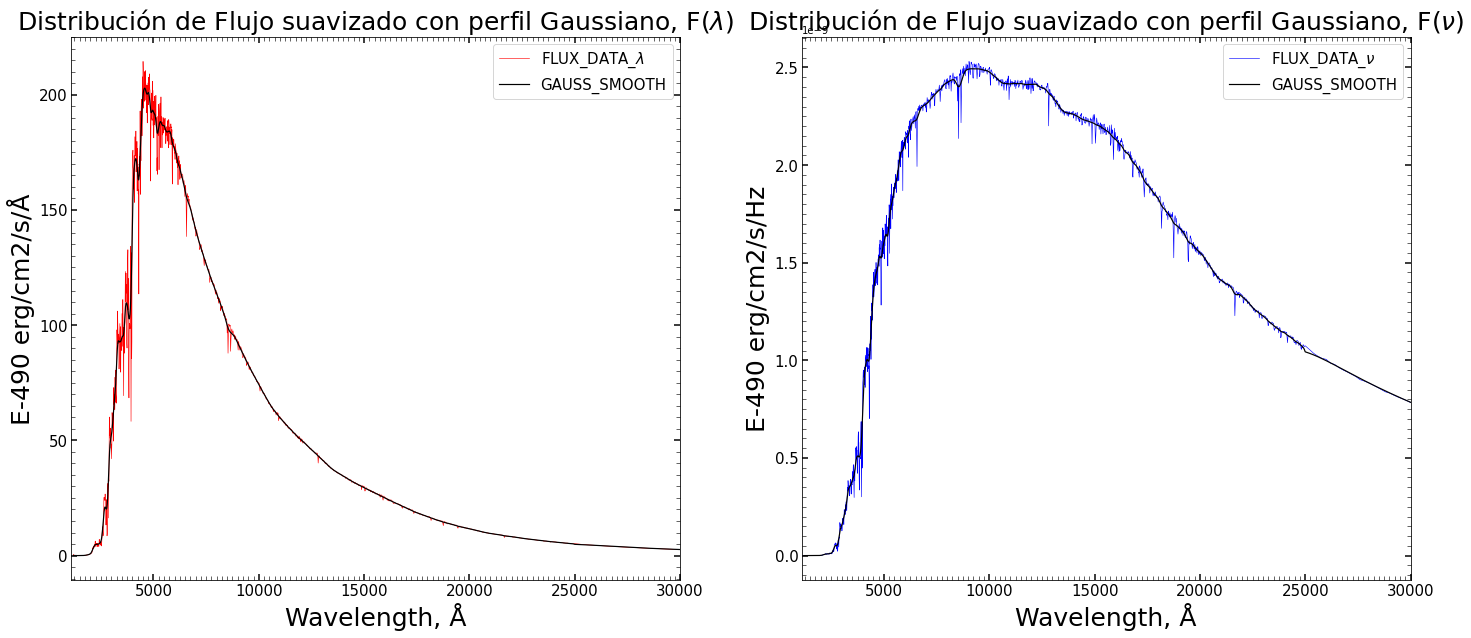

In [122]:
# Graficamos el espectro (en función de lambda) junto al espectro suavizado

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 10))
ax1.plot(spec["Wavelength, Å"], spec["E-490 erg/cm2/s/Å"], c="red", label=r'FLUX_DATA_$\lambda$', linewidth=0.6)
ax1.plot(spec["Wavelength, Å"], smooth_spec_lambda, c="black", label='GAUSS_SMOOTH', linewidth=1.2)
ax1.set_title(r'Distribución de Flujo suavizado con perfil Gaussiano, F($\lambda$)', fontsize=25)
ax1.set_ylabel('E-490 erg/cm2/s/Å', fontsize=25)
ax1.set_xlabel('Wavelength, Å', fontsize=25)
ax1.set_xlim(1100, 30000)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)

ax1.xaxis.set_minor_locator(MultipleLocator(250))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)
ax1.legend(fontsize=15, markerscale=5)

ax2.plot(spec["Wavelength, Å"], spec["E-490 erg/cm2/s/Hz"], c="blue", label=r'FLUX_DATA_$\nu$', linewidth=0.6)
ax2.plot(spec["Wavelength, Å"], smooth_spec_freq, c="black", label='GAUSS_SMOOTH', linewidth=1.2)
ax2.set_title(r'Distribución de Flujo suavizado con perfil Gaussiano, F($\nu$)', fontsize=25)
ax2.set_ylabel('E-490 erg/cm2/s/Hz', fontsize=25)
ax2.set_xlabel('Wavelength, Å', fontsize=25)
ax2.set_xlim(1100, 30000)

ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)

ax2.xaxis.set_minor_locator(MultipleLocator(250))
ax2.yaxis.set_minor_locator(MultipleLocator(0.00000000005))
ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)
ax2.legend(fontsize=15, markerscale=5)

El flujo monocromático total, es la suma de los aportes de flujo monocromático en todas las frecuencias (en la formulación $F_{\nu}$) o longitudes de onda (en la formulación $F_{\lambda}$):

$$F = \int_{0}^{\infty} F_{\nu}d\nu = \int_{0}^{\infty} F_{\lambda}d\lambda$$

(Clocchiatti & Catelan, 2017, p.17)


In [123]:
# Utilizando la función trapezoid de scipy.integrate, integramos las funciones suavizadas,
# tanto de longitud de onda como de frecuencia, aproximando por trapezoides, a lo largo de todo el rango
# de frecuencias y longitudes de onda que tenemos en los datos.

integrar_flujo_lambda = trapezoid(spec["Wavelength, Å"], x= - smooth_spec_lambda)* u.erg * u.cm ** -2 * u.s ** -1
integrar_flujo_freq = trapezoid(spec["Frequency, Hz"], x=  smooth_spec_freq)* u.erg * u.cm ** -2 * u.s ** -1

flujo_freq_si = integrar_flujo_freq.to(u.W * u.m ** -2)
flujo_lambda_si = integrar_flujo_lambda.to(u.W * u.m ** -2)

print("Flujo monocromático total, integrada sobre longitudes de onda: {}\n"
     "Flujo monocromático total, integrada sobre frecuencias: {}".format(
           flujo_lambda_si.round(3),
           flujo_freq_si.round(3)))

err_int = (integrar_flujo_lambda - integrar_flujo_freq) * 100 / integrar_flujo_lambda
print("Error: {}%".format(err_int.round(5)))

Flujo monocromático total, integrada sobre longitudes de onda: 1367.291 W / m2
Flujo monocromático total, integrada sobre frecuencias: 1366.334 W / m2
Error: 0.07002%


Observamos que, los flujos totales encontradas integrando sobre longitudes de onda y sobre frecuencias son prácticamente equivalentes, si bien la teoría nos dice que deberían ser exactamente equivalentes, la discrepancia encontrada en ambos valores radica en los errores que puede aportar tanto la "suavización" de los espectros como la aproximación por trapezoides que hace la función _trapezoid_. De todas maneras, el error es muy pequeño, menos del 0.1%.

**e) Obtener la luminosidad total del Sol, a partir de los resultados obtenidos en los ítems anteriores.**

La energía total emitida por una estrella por unidad de tiempo, en todas las direcciones y en todas las longitudes de onda, es llamada _luminosidad_ y suele designarse con la letra L. Como el flujo es la cantidad total de energía por unidad de área y de tiempo, en la superficie de una estrella de radio $R_{s}$ que emite energía de manera isotrópica, la siguiente relación debe ser válida:

$$F(R_{s}) = \frac{L}{4\pi R_{s}^{2}}$$

Luego, al despejar para $L$, obtenemos una expresión para la luminosidad de una estrella de radio $R_{s}$:

$$L = 4\pi R_{s}^{2} F$$

Sin embargo, para calcular la luminosidad del Sol, necesitamos conocer el flujo total en la superficie del Sol, y el flujo que tenemos es el registrado en la atmósfera de la Tierra. Para calcular el flujo en la superficie del Sol utilizaremos la ley del inverso cuadrado de la distancia. Sabemos que, dada una fuente puntual que produce un flujo isotrópico, y dadas dos regiones esféricas del espacio cuyo origen se encuentra en la fuente puntual, una de radio $r_{1}$ y la otra de radio $r$, donde $r>r_{1}$, el flujo medido a una distancia $r$ con respecto al flujo medido a una distancia $r_{1}$ se relacionan de la siguiente manera:

$$F(r) = F(r_{1})\frac{r_{1}^2}{r^2}$$

(Clocchiatti & Catelan, 2017, p.8)

Luego, podemos utilizar esta expresión para calcular el flujo en la superficie del Sol utilizando las siguientes definiciones, asumiendo que la fuente puntual que produce flujo isotrópico se encuentra en el centro del Sol:
* $F(r)$: Flujo medido en la atmósfera terrestre
* $F(r_{1})$: Flujo medido en la superficie del Sol
* $r$: Distancia desde el núcleo del Sol hasta la atmósfera terrestre: $R_{\odot} + 1$ UA 
* $r_{1}$: Distancia desde el núcleo del Sol hasta la superficie solar (radio solar): $R_{\odot}$

In [124]:
# Utilizando el radio del Sol proporcionado por la librería astropy, calculamos la luminosidad de la estrella como:

distance_scale = (const.R_sun.to(u.m) ** 2 / (const.R_sun.to(u.m) + const.au.to(u.m)) ** 2)

l_sun_lambda = 4 * np.pi * (const.R_sun.to(u.m) ** 2) * (flujo_lambda_si / distance_scale)
l_sun_freq = 4 * np.pi * (const.R_sun.to(u.m) ** 2) * (flujo_freq_si / distance_scale)

print("Radio del sol proporcionado por la librería Astropy: {}".format(const.R_sun.to(u.m)))
print("Luminosidad calculada con flujo en función de longitud de onda: {}".format(l_sun_lambda))
print("Luminosidad calculada con flujo en función de frecuencia: {}".format(l_sun_freq))
print("Luminosidad proporcionada por la librería Astropy (International Astronomical Union, 2009): {}".format(const.L_sun))

Radio del sol proporcionado por la librería Astropy: 695700000.0 m
Luminosidad calculada con flujo en función de longitud de onda: 3.8810720487631294e+26 W
Luminosidad calculada con flujo en función de frecuencia: 3.878354347108316e+26 W
Luminosidad proporcionada por la librería Astropy (International Astronomical Union, 2009): 3.828e+26 W


**f) Asumiendo que el Sol es una fuente esférica que emite una intensidad específica uniforme en todas las direcciones, y adoptando los valores para el radio solar y la distancia promedio Tierra-Sol (Unidad Astronómica) más actualizados que usted logre encontrar en la literatura, calcule la intensidad específica solar, integrada sobre todas las frecuencias disponibles.**

Conocemos una expresión que relaciona el flujo total con la intensidad total:

$$F = \int_{\Omega} I \cos{(\theta)} d \Omega$$

Donde $F$ es el flujo total, $I$ es la intensidad específica integrada sobre todas las frecuencias, $\cos{\theta}$ la componente de ángulo de incidencia de los rayos, y $\Omega$ el ángulo sólido que abarca el Sol visto desde la superficie terrestre. Si asumimos una intensidad uniforme en todas las direcciones, es decir, isotrópica, estamos diciendo que $I \neq I(\theta,\varphi)$, por lo tanto, podemos tratar la intensidad como una constante y "sacarla de la integral":

$$\Rightarrow \hspace{3mm} F = I \int_{\Omega} \cos{(\theta)} d \Omega$$

Además, dada la gran distancia entre la Tierra y el Sol, podemos considerar que los rayos de luz llegan prácticamente perpendiculares a la superficie del planeta, es decir, llegan con un ángulo de $\theta = 0$, luego,

$$\cos{(0)} = 1 \\ \Rightarrow \hspace{3mm} F = I \int_{\Omega} d \Omega$$

La integral de ángulo sólido es trivial, y la ecuación queda expresada de la siguiente manera:

$$F = I\Omega$$

Luego, tenemos una expresión para la intensidad específica solar:

$$I = \frac{F}{\Omega}$$

Ahora, veamos la definición de ángulo sólido $\Omega$:

$$\Omega = \frac{S}{R^{2}}$$

Donde $S$ es el área de la sección de ángulo sólido, y $R$ es la distancia entre el origen del marco de referencia hasta la región del ángulo sólido. Como el ángulo sólido que estamos considerando es la región (en esterradianes) que ocupa el Sol en el cielo terrestre, tenemos que $S$ será el área circular que ocupa el Sol, es decir, $S = \pi R_{\odot}^{2}$, donde $R_{\odot}$ es el radio del Sol; además, como la distancia que estamos considerando es la distancia entre la Tierra y el Sol, definimos $R = 1$ UA. Una vez definido el ángulo sólido, tenemos:

$$\Omega = \frac{\pi R_{\odot}^{2}}{1 \text{UA}^{2}}$$

$$\Rightarrow \hspace{3mm} I = \frac{F}{\frac{\pi R_{\odot}^{2}}{1 \text{UA}^{2}}}$$
$$\Rightarrow \hspace{3mm} I = F\cdot\frac{1 \text{UA}^{2}}{\pi R_{\odot}^{2}}$$

Así, tenemos una expresión que expresa la intensidad específica solar total como función del flujo (que ya conocemos de un inciso anterior), la distancia Tierra-Sol y el radio Solar.

In [125]:
# Utilizaremos el flujo integrado sobre todas las frecuencias

flujo_freq_si

<Quantity 1366.3338152 W / m2>

In [126]:
# Con la expresión que definimos, y con las constantes proporcionadas por Astropy,
# calculamos la intensidad específica solar total

omega_sterrad = ((const.au.to(u.m)) ** 2 / (np.pi * (const.R_sun.to(u.m) ** 2))) * u.sr ** -1
sp_intensity_sun = flujo_freq_si * omega_sterrad
print("Intensidad específica solar total:")
sp_intensity_sun.to(u.MW * u.m ** -2 * u.sr**-1)

Intensidad específica solar total:


<Quantity 20.11007829 MW / (m2 sr)>

**g) Busque la definición y significado de _constante solar_ en la literatura, y verifique si sus resultados son compatibles con los valores aceptados.**

Según Zirin (1998): _"La constante solar es la energía total de radiación recibida del Sol por unidad de tiempo y unidad de superficie en una superficie teórica perpendicular a los rayos solares y a la distancia media de la Tierra al Sol. Se mide con mayor precisión desde satélites ya que no hay efectos atmosféricos. El valor de la constante es de aproximadamente 1,366 kW por metro cuadrado."_

En el inciso d), calculamos el flujo monocromático total integrado sobre longitudes de onda y sobre frecuencias, con datos que muestran el flujo que se recibe por encima de la atmósfera. Los resultados que obtuvimos para ambas integraciones fueron $1367.291 \frac{W}{m^2}$ y $1366.334 \frac{W}{m^2}$ respectivamente, resultados que son consistentes con lo expuesto en la teoría, por lo que podemos concluir que pudimos obtener exitosamente la constante solar, con los datos proporcionados por la _National Renewable Energy Laboratory_. Cabe mencionar que la constante tiene pequeñas variaciones en función de los diferentes períodos de actividad solar, además de que se estiman mejores valores cada vez debido al refinamiento de los instrumentos. En Kopp (2011), se expone un nuevo valor para la constante solar, menor al que se habría establecido en los '90, que equivale a $1360.8 ± 0.5 \frac{W}{m^2}$ en base a las mediciones tomadas por el Total Irradiance Monitor (TIM) en el Solar Radiation and Climate Experiment (SORCE) de la NASA junto con una serie de pruebas radiométricas de laboratorio. Usando este valor, podemos estimar el error de nuestras mediciones con respecto al valor de la literatura:

In [127]:
def percent_err_csun(csun_theory, csun_measured, err):
    abs_diff = np.abs(csun_measured - csun_theory)
    percent_diff = np.round((abs_diff * 100) / csun_theory, 4)
    return percent_diff, err

csun_theory = 1360.8 * u.W * u.m ** -2
err_freq = percent_err_csun(csun_theory, flujo_freq_si, 0.5)
err_wavelen = percent_err_csun(csun_theory, flujo_lambda_si, 0.5)

print("Error de constante solar integrada sobre frecuencia: {} ± {}%".format(err_freq[0], err_freq[1]))
print("Error de constante solar integrada sobre longitud de onda: {} ± {}%".format(err_wavelen[0], err_wavelen[1]))

Error de constante solar integrada sobre frecuencia: 0.4067 ± 0.5%
Error de constante solar integrada sobre longitud de onda: 0.477 ± 0.5%


### 2.- Una _vela solar_ consiste en un tipo de propulsor que se ha propuesto como alternativa a motores tradicionales para viajes espaciales. En este problema, usted utilizará los conceptos estudiados en clase para evaluar la factibilidad de utilizar este tipo de propulsor en una nave espacial. Para tanto, considere un prototipo con una vela cuadrada de 10 $m^{2}$, perfectamente reflectora, adosada a una nave cuya masa total es de 10 kg.

**a) Si la nave es colocada en el espacio a una distancia de 1 UA del Sol, y además la superficie de la vela se encuentra orientada de forma a estar siempre perpendicular al radio vector que une la nave al Sol, ¿cuánto vale la presión de radiación solar sobre la nave?**

La presión del campo radiativo total, integrado sobre todo el rango de frecuencias, se expresa de la siguiente manera:

$$P = \frac{1}{c}\int_{\Omega} I \cos^{2}{(\theta)}d\Omega$$

Donde $I$ es la intensidad (en este caso) específica solar total sobre un ángulo sólido $\Omega$, $\theta$ el ángulo de incidencia de los rayos y $c$ la velocidad de la luz. 

(Clocchiatti & Catelan, 2017, p.19)

Dado que estamos considerando intensidad isotrópica, $I \neq I(\theta, \varphi)$, podemos sacar este término de la integral, y, además, como estamos considerando rayos que inciden completamente perpendiculares a la vela, tenemos que su ángulo de incidencia es $\theta = 0$, y por lo tanto, $\cos^{2}{(0)} = 1$, además como la superficie de la vela es perfectamente reflectante, lo obtenido será multiplicado por dos para considerar el momentum asociado, luego, la expresión queda de la siguiente forma:

$$P = \frac{2I}{c}\int_{\Omega}d\Omega$$

La integral es trivial y la expresión resulta:

$$P = \frac{2I}{c}\cdot\Omega$$

De manera análoga a los cálculos realizados en el inciso 1.f), definimos el ángulo sólido $\Omega$ como:

$$\Omega = \frac{S}{R^{2}} = \frac{\pi R_{\odot}^{2}}{1\text{UA}^2}$$

Luego,

$$P = \frac{2I}{c}\cdot\frac{\pi R_{\odot}^{2}}{1\text{UA}^2}$$

Además, del inciso 1.f) obtuvimos una expresión para la intensidad específica total solar:

$$I = 2F\cdot\frac{1 \text{UA}^{2}}{\pi R_{\odot}^{2}}$$

Que, reemplazándola en nuestra expresión de presión resulta:

$$P = 2F\cdot\frac{1 \text{UA}^{2}}{\pi R_{\odot}^{2}}\frac{1}{c}\cdot\frac{\pi R_{\odot}^{2}}{1\text{UA}^2}$$

$$\Rightarrow\hspace{3mm} P = 2F\cdot\frac{\cancel{1 \text{UA}^{2}}}{\cancel{\pi R_{\odot}^{2}}}\frac{1}{c}\cdot\frac{\cancel{\pi R_{\odot}^{2}}}{\cancel{1 \text{UA}^{2}}}$$

$$\Rightarrow\hspace{3mm} P = \frac{2F}{c}$$


Finalmente obtenemos una ecuación que expresa la presión de radiación en función del flujo monocromático total y la velocidad de la luz.

In [168]:
# Utilizamos el flujo monocromático total integrado sobre todas las frecuencias
# (En este caso utilizamos el mismo flujo que se observaría por encima de la atmósfera
# terrestre, ya que la nave se encuentra a 1 UA y por lo tanto recibe el mismo flujo
# que recibe la Tierra sin efectos atmosféricos),
# y la velocidad de la luz proporcionada por Astropy

rad_pressure_sail = (flujo_freq_si / const.c) * 2
print("Presión de radiación solar sobre la nave: {}".format(rad_pressure_sail.to(u.Pa)))


Presión de radiación solar sobre la nave: 9.115198056135108e-06 Pa


**b) Debido a esa presión de radiación, la nave adquirirá momentum. ¿Cuánto vale la aceleración correspondiente, si ninguna otra fuerza actúa sobre la nave?**

De mecánica clásica, sabemos que la presión que se ejerce sobre un cuerpo es fuerza por unidad de área:

$$P = \frac{F}{A}$$

Y, por segunda ley de Newton, la sumatoria de fuerzas sobre un objeto se puede expresar como la masa del objeto por su aceleración:

$$\sum \vec{F} = m\vec{a}$$

Luego, conociendo la presión que ejerce la radiación sobre la vela, y ninguna otra fuerza actúa sobre la nave, combinando las ecuaciones podemos obtener la siguiente expresión para la aceleración de la nave:

$$P_{\text{vela}} = \frac{ma}{A}$$

$$\Rightarrow\hspace{3mm} \frac{P_{\text{vela}}\cdot A}{m} = a$$

Donde $A$ es el área de la vela, $m$ la masa de la nave y "a" el módulo de su aceleración.

In [129]:
# Usamos el valor encontrado para la presión de radiación encontrado
# en el inciso anterior

sail_area = 10 * u.m **2
ship_weight = 10 * u.kg
rad_pressure_sail_si = rad_pressure_sail.to(u.kg * u.s ** -2 * u.m ** -1)

ship_acc = (rad_pressure_sail_si * sail_area) / ship_weight
print("Aceleración de la vela debido a la presión de radiación solar: {}".format(
    ship_acc
))

Aceleración de la vela debido a la presión de radiación solar: 9.115198056135108e-06 m / s2


**c) Compare su resultado con valores de aceleración típicos encontrados en situaciones cotidianas de su elección, y discuta sus resultados.**

Un estudio realizado por Wilson y González-Alonso (2011) encontró que la aceleración máxima que un ciclista puede mantener durante un corto período de tiempo (5-10 segundos) es de aproximadamente 5 $\frac{m}{s^{2}}$. Al comparar este valor con la aceleración de la vela solar mendiante un porcentaje obtenemos:

La aceleración de una bicicleta por persona promedio es de 5 $\frac{m}{s^{2}}$, al comparar este valor con la aceleración de la vela 


In [130]:
ac_bici = 5
ac_vela = 9.12e-06

diferencia_porcentual = ((ac_vela) * 100 / ac_bici)
print("La diferencia en este ejemplo está dada por: {}%".format(diferencia_porcentual))


La diferencia en este ejemplo está dada por: 0.00018240000000000002%


Por lo que la vela es un 0.00012% más lenta que un ciclista, lo que significa que la aceleración de la vela es demasiado pequeña, por lo que resulta cuestionable su eficiencia.


**d) Calcule ahora la aceleración de la gravedad debido al Sol en la posición de la nave, y discuta la factibilidad del prototipo. ¿Qué cambiaría usted, para mejorar las chances de éxito de una tal nave?**

Podemos calcular la aceleración de gravedad utilizando la ecuación de gravitación de Newton:

$$F_{G} = G\frac{m_{1}\cdot m_{2}}{r^{2}}$$

Que expresa la fuerza gravitacional entre dos masas $m_{1}$ y $m_{2}$ que están separadas por una distancia $r$, dada la constante de gravitación universal $G$.

Por segunda ley de Newton podemos escribir $F_{G} = m\cdot a$, donde, en nuestro caso particular, $m$ es la masa de la nave y $a$ su aceleración. Luego, podemos encontrar una expresión para la aceleración de la nave dada la interacción gravitatoria entre ésta y el Sol a una distancia $r = 1 \text{UA}$:

$$ma = G\frac{M_{\odot}\cdot m}{1\text{UA}^{2}}$$

$$\Rightarrow\hspace{3mm} a = G\frac{M_{\odot}}{1\text{UA}^{2}}$$

Notamos que esta expresión no depende de la masa de la nave, y es que la aceleración debido a la acción gravitatoria de un cuerpo sólo depende de su masa y de la distancia a la que otro cuerpo se encuentre.

In [131]:
sun_grav_acc_oneau = const.G * const.M_sun / const.au ** 2
print("Aceleración debido a la gravedad del Sol a 1UA: {}".format(sun_grav_acc_oneau))
acc_percent_equivalence = ship_acc * 100 / sun_grav_acc_oneau
print("La aceleración debido a la presión de radiación equivale a un {}% de la aceleración por gravedad del Sol".format(
    acc_percent_equivalence
))

Aceleración debido a la gravedad del Sol a 1UA: 0.0059300835181528 m / s2
La aceleración debido a la presión de radiación equivale a un 0.15371112444255186% de la aceleración por gravedad del Sol


Vemos inmediatamente que este modelo de vela solar no es factible para viajes en el espacio, ya que la gravedad del Sol es ~99% más fuerte que la presión de radiación, por lo que, a esta distancia del Sol, para tiempos muy grandes eventualmente la nave terminará engullida por el Sol.

Para plantear un modelo que nos sirva para una nave de las mismas dimensiones, podemos mejorar el tamaño de la vela, o aumentar la distancia inicial entre la vela y el Sol. Si decidimos aumentar la distancia entre la vela y el Sol, podemos plantear dos funciones de aceleración que dependan de la distancia, y compararlas. Definimos la aceleración debido a la presión de radiación como:

$$a_{p}(r) = \frac{P_{\text{vela}}\cdot A}{m}$$

$$P_{\text{vela}} = \frac{2F(r)}{c}$$

$$F(r) = F(R_{\odot})\frac{R_{\odot}^2}{r^2}$$

$$P_{\text{vela}} = \frac{2F(R_{\odot})R_{\odot}^2}{cr^{2}}$$

$$\Rightarrow\hspace{3mm} a_{p}(r) = F(R_{\odot})\frac{2A}{mc}\frac{R_{\odot}^2}{r^{2}}$$

Y definimos la aceleración debido a la acción gravitatoria solar como:

$$a_{g}(r) = G\frac{M_{\odot}}{r^{2}}$$

A partir de las fórmulas descritas anteriormente, definimos dos funciones y creamos un array con 10000 datos entre 0 y 200 UA, para observar el comportamiento de ambas aceleraciones y ver si hay alguna distancia en la que, dada esta configuración de masa y área de la vela, sea un prototipo factible.

In [132]:
def acc_due_sun_gravity(distance):
    return ((const.G * const.M_sun) / ((distance * u.au).to(u.m)) ** 2).value

def acc_due_pressure(distance, area):
    aux_1 = (2 * area * u.m ** 2) / (10 * u.kg * const.c)
    dist_aux = (const.R_sun + const.au) ** 2 / ((distance * u.au).to(u.m)) ** 2
    return (aux_1 * flujo_freq_si * dist_aux).value

In [140]:
distances = np.linspace(0, 200, 10000)
distances_au = []
for dist in distances:
    dist_au = (dist * u.au)
    distances_au.append(dist_au.value)

c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


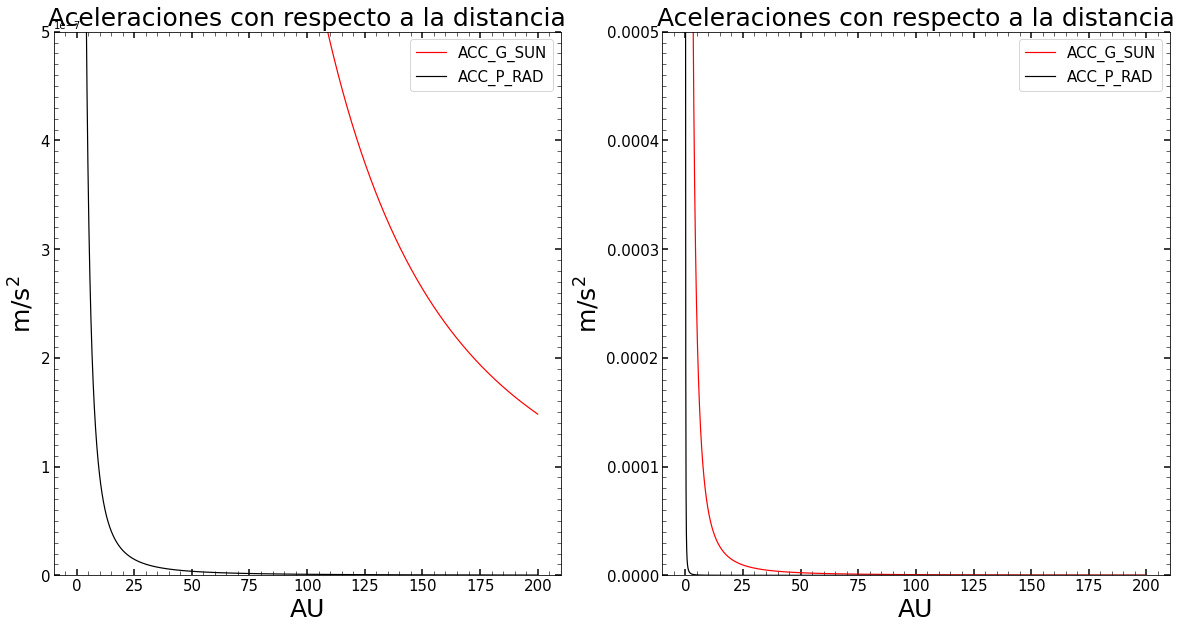

In [163]:
# Ploteamos dos gráficas, con límites verticales distintos para
# observar el comportamiento de las funciones

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1.plot(distances_au, acc_due_sun_gravity(distances_au), c="red", label='ACC_G_SUN', linewidth=1.2)
ax1.plot(distances_au, acc_due_pressure(distances_au, 10), c="black", label='ACC_P_RAD', linewidth=1.2)
ax1.set_title('Aceleraciones con respecto a la distancia', fontsize=25)
ax1.set_ylabel(r'm/s$^{2}$', fontsize=25)
ax1.set_xlabel('AU', fontsize=25)
ax1.set_ylim(0, 0.0000005)


ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)

ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(MultipleLocator(0.00000001))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)
ax1.legend(fontsize=15, markerscale=5)

ax2.plot(distances_au, acc_due_sun_gravity(distances_au), c="red", label='ACC_G_SUN', linewidth=1.2)
ax2.plot(distances_au, acc_due_pressure(distances_au, 10), c="black", label='ACC_P_RAD', linewidth=1.2)
ax2.set_title('Aceleraciones con respecto a la distancia', fontsize=25)
ax2.set_ylabel(r'm/s$^{2}$', fontsize=25)
ax2.set_xlabel('AU', fontsize=25)
ax2.set_ylim(0, 0.0005)
ax2.legend(fontsize=15, markerscale=5)
ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.00001))
ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)

Observamos que para este modelo, dado el área de la vela y la masa de la nave, concluimos que no es factible para ninguna distancia inicial, ya que para cualquier distancia, siempre la aceleración debido a la gravedad solar será mayor o igual que la aceleración debido a la presión, y, observando las tendencias del gráfico, podemos ver que serán iguales sólo para valores muy cercanos a cero.

Podemos adoptar un nuevo modelo de vela solar, a la misma distancia pero con un área mayor. Así, podemos escribir una expresión que nos entregue el área de vela mínima necesaria para que la aceleración por presión de radiación sea mayor a la gravitatoria solar. Dada la expresión para la aceleración:

$$\frac{P_{\text{vela}}\cdot A}{m} = a$$

Donde $m$ es la masa de la nave y $a$ es la aceleración debido a la gravedad solar. Luego,

$$ A = \frac{ma_{g\odot}}{P_{\text{vela}}}$$


In [135]:
min_area = 10 * u.kg * sun_grav_acc_oneau / rad_pressure_sail_si
print("Dada una vela cuadrada, el valor mínimo que debe tomar el lado de la vela es de {}, para que la aceleración por presión de radiación sea mayor al tirón gravitatorio solar.".format(
    np.sqrt(min_area)))

Dada una vela cuadrada, el valor mínimo que debe tomar el lado de la vela es de 80.6579816504352 m, para que la aceleración por presión de radiación sea mayor al tirón gravitatorio solar.


**e) Adopte ahora nuevos parámetros para la nave según las ideas propuestas por usted en el ítem anterior. Asumiendo que la aceleración se mantiene constante y la nave se aleja radialmente del Sol, ¿cuál será su velocidad, luego de 1 año de funcionamiento?**

A partir de los resultados obtenidos en el Item anterior, notamos que cuando un lado de la vela es igual a 80 metros aproximadamente, esta se mantendrá fija, dado que las aceleraciones serán iguales. Por lo tanto, asumiremos un lado de la vela igual a 100 metros.  

c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Users\56974\AppData\Local\Programs\Python\Python310\lib\site-packages\astropy\units\quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


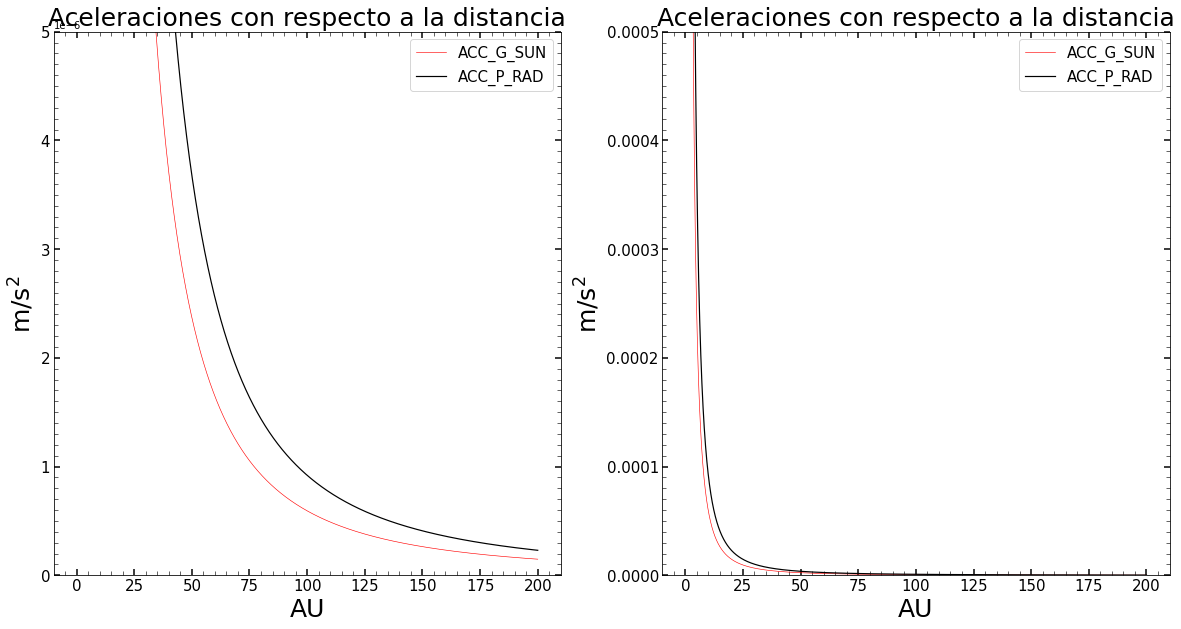

In [167]:
# Ploteamos dos gráficas, con límites verticales distintos para
# observar el comportamiento de las funciones

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1.plot(distances_au, acc_due_sun_gravity(distances_au), c="red", label='ACC_G_SUN', linewidth=0.6)
ax1.plot(distances_au, acc_due_pressure(distances_au, 10000), c="black", label='ACC_P_RAD', linewidth=1.2)
ax1.set_title('Aceleraciones con respecto a la distancia', fontsize=25)
ax1.set_ylabel(r'm/s$^{2}$', fontsize=25)
ax1.set_xlabel('AU', fontsize=25)
ax1.set_ylim(0, 0.000005)


ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)

ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(MultipleLocator(0.0000001))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)
ax1.legend(fontsize=15, markerscale=5)

ax2.plot(distances_au, acc_due_sun_gravity(distances_au), c="red", label='ACC_G_SUN', linewidth=0.6)
ax2.plot(distances_au, acc_due_pressure(distances_au, 10000), c="black", label='ACC_P_RAD', linewidth=1.2)
ax2.set_title('Aceleraciones con respecto a la distancia', fontsize=25)
ax2.set_ylabel(r'm/s$^{2}$', fontsize=25)
ax2.set_xlabel('AU', fontsize=25)
ax2.set_ylim(0, 0.0005)
ax2.legend(fontsize=15, markerscale=5)
ax2.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.00001))
ax2.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True)

A partir del gráfico, podemos notar que para los parámetros específicados en esta vela, independientemente del valor de la distancia que tomemos (en este caso desde 0 a 200 UA), la aceleración con respecto a la presión de radiación será mucho mayor que la ejercida por la gravitación del Sol.

Ahora, dada nuestro prototipo de vela cuadrada cuya arista mide 100 metros, podemos calcular, análogamente al inciso 2.b), la aceleración debido a la presión de radiación, dada la nueva área y asumiendo un material ultradelgado, de forma que no afecta la masa de la nave. Luego, conociendo el valor de la aceleración debido a la interacción gravitatoria del Sol a una distancia de 1 UA, podemos calcular la velocidad de la nave en función del tiempo a través de la siguiente expresión:

$$v(t) = (a_{p} - a_{g\odot})t$$

Dado esto, podemos encontrar la velocidad de la nave tras 1 año de viaje.

In [137]:
# los segundos del año son proporcionados por la conversión de astropy (31557600s)
t = (1 * u.year).to(u.s)
ap = (rad_pressure_sail_si * 10000 * u.m**2) / (10 * u.kg) 
ag = (sun_grav_acc_oneau)
v = ((ap - ag) * t).to(u.km * u.h **-1)

print("La velocidad que adquirirá la vela luego de un año de funcionamiento es igual a: {}".format(v))

La velocidad que adquirirá la vela luego de un año de funcionamiento es igual a: 361852.4539577897 km / h


**f) Repita el cálculo realizado en el ítem anterior, asumiendo que, en vez de orientarse en forma paralela al radio vector nave-Sol, la normal a la superficie de la vela se mantiene inclinada por un ángulo de 45° con respecto a esa dirección.**

Del inciso 2a) obtuvimos que la presión de radiación solar sobre la nave considerando el momentum corresponde a:

$$P = \frac{2}{c}\int_{\Omega} I \cos^{2}{(\theta)}d\Omega$$
Por enunciado tenemos que:

$$\theta = 45° \rightarrow \cos^{2}{(\theta)} = \frac{1}{2}$$ 
Por lo tanto, 

 $$P = \frac{I}{c}\int_{\Omega}d\Omega$$
Ahora considerando las mismas condiciones del enunciado para theta, usamos la fórmula de flujo para despejar la intensidad, lo que nos queda:

$$I = F\sqrt{2}\cdot\frac{1 \text{UA}^{2}}{\pi R_{\odot}^{2}}$$
Reemplazando esta fórmula en la de la presión obtenemos:

$$P = F\sqrt{2}\cdot\frac{1 \text{UA}^{2}}{\pi R_{\odot}^{2}}\frac{1}{c}\cdot\frac{\pi R_{\odot}^{2}}{1\text{UA}^2}$$
Luego al simplificar, finalmente la presión de radiación solar para este caso es

$$\Rightarrow\hspace{3mm} P = \frac{F\sqrt{2}}{c}$$


In [138]:
# Utilizamos el flujo monocromático total integrado sobre todas las frecuencias
# la velocidad de la luz proporcionada por Astropy

rad_pressure_sail_45 = (flujo_freq_si * np.sqrt(2) / const.c)*2
print("Presión de radiación solar sobre la nave cuando esta inclinada 45°: {}".format(rad_pressure_sail_45.to(u.Pa)))

Presión de radiación solar sobre la nave cuando esta inclinada 45°: 1.2890836714703144e-05 Pa


**g) Bajo las mismas condiciones que en el ítem e), ¿en cuánto tiempo la nave alcanzaría una velocidad relativista, es decir, del orden de 1% de la velocidad de la luz o superior?**

$$\frac{c}{100} = (a_{p} - a_{g\odot})t$$

$$\Rightarrow\hspace{3mm} \frac{c}{100(a_{p} - a_{g\odot})} = t$$

In [139]:
t_final = const.c / (100 * (ap - ag))
print("Bajo las condiciones del ítem e), la nave llegará a velocidad relativista en {}".format(t_final.to(u.year)))

Bajo las condiciones del ítem e), la nave llegará a velocidad relativista en 29.825771167103795 yr


**h) Obtenga la ecuación de movimiento de la nave, en función de su masa $m$, tamaño de arista de la vela cuadrada $\boldsymbol\ell $ y ángulo de inclinación de la vela $\theta$, tomando en cuenta la dilución geométrica para el flujo y la dependencia de la aceleración de la gravedad solar con la distancia. ¿Qué estrategias utilizaría usted para integrar esa ecuación?**

Para obtener la ecuación de movimiento, podemos guiarnos de lo aprendido en mecánica clásica. En ese sentido, podemos realizar un diagrama de cuerpo libre para obtener lobtener las fuerza, con esto, mediante la segunda ley de Newton (F = m*a) será posible obtener la aceleración. Además, sabemos que la ecuación de movimiento está dada por:

$$\frac{dx}{dt} = v_{0} + at$$

donde

$$v_{0} = 0$$


Caso para intensidad no isotrópica:

$$\frac{dx(t)}{dt} = \left(\frac{P_{\text{vela}}\cdot A}{m} - {a_{G}}\right)t$$
donde, la presión de radiación de la vela en función del ángulo de la normal de los rayos incidentes (theta) es:
$$P_{\text{vela}} = \frac{2}{c}\int_{\Omega} I{(\theta,\varphi)} \cos^{2}{(\theta)}d\Omega$$
el área de la vela respecto sus aristas:
$$A = \boldsymbol\ell^{2}$$
y finalmtente la aceleración debido la gravedad del Sol:
$$ {a_{G}} = G\frac{M_{\odot}}{x^{2}} $$
reemplazando estas fórmulas obtenemos,
$$\frac{dx(t)}{dt} = \left(\frac{\frac{2}{c}\int_{\Omega} I{(\theta,\varphi)} \cos^{2}{(\theta)}d\Omega\cdot \boldsymbol\ell^{2}}{m} - G\frac{M_{\odot}}{x^{2}}\right)t$$

$$x(t) = \int_{\Delta t} \left(\frac{\frac{2}{c}\int_{\Omega} I{(\theta,\varphi)} \cos^{2}{(\theta)}d\Omega\cdot \boldsymbol\ell^{2}}{m} - G\frac{M_{\odot}}{x^{2}}\right)t dt$$

Caso para intensidad isotrópica:

$$\frac{dx(t)}{dt} = \left(\frac{\frac{2I}{c}\int_{\Omega}\cos^{2}{(\theta)}d\Omega\cdot \boldsymbol\ell^{2}}{m} - G\frac{M_{\odot}}{x^{2}}\right)t$$

Para calcular estas integrales podemos utilizar aproximaciones polinomiales o también es posible usar el método de los trapecios para aproximar la integral numéricamente, puesto que no se puede resolver esta integral de manera analítica. 
Por otro lado, también es posible asignarle valores a todas las constantes de manera tal que se pueda omitir la integral como tal. De esta forma, será posible encontrar la posición $x(t)$ en cualquier momento $t$.

### **Bibliografía**
* Clocchiatti, A., & Catelan, M. (2017). Radiación y materia en astrofísica (Spanish Edition). Ediciones UC.
* International Astronomical Union. (2009). The IAU Strategic Plan 2010-2020: Astronomy for Development
* Zirin, H. (1998, 20 julio). Solar constant. Encyclopedia Britannica. https://www.britannica.com/science/solar-constant
* Wilson, G. J., & González-Alonso, J. (2011). Maximum rate of increase in heart rate during the transition from moderate to severe exercise conditions. European journal of applied physiology, 111(3), 395-397.